In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42129")
client

<Client: 'tcp://127.0.0.1:42129' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import gsw
import numpy.testing as npt
from MITgcmutils import rdmds
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
import xrft
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.ticker as mticker
%matplotlib inline

In [3]:
gridir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
file_ocean = '/tank/chaocean/qjamet/RUNS/ORAR/memb'
file2_ocean = '/tank/chaocean/bill/RUNS/ORAR/poje/'
ddir = '/tank/chaocean/bill/RUNS/ORAR/ensmean/'
savedir = '/tank/topog/tuchida/EOF/'

In [4]:
dg = open_mdsdataset(ddir, grid_dir=gridir,
                     prefix=['umjan1967'])
dg

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47, Zu: 46, Zl: 46)
Coordinates: (12/31)
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
  * Zp1      (Zp1) >f4 0.0 -6.094 -12.81 -19.91 ... -5.5e+03 -5.75e+03 -6e+03
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [5]:
DRF = dg.drF
RAC = dg.rA
DXC = dg.dxC
DYC = dg.dyC
# RC=rdmds('/tank/chaocean/grid_chaO/gridMIT_update1/RC');
ny, nx = RAC.shape
nz = len(DRF);
yearfirst=1970; yearlast=1995;
yearyearfirst=1963;
memberfirst=0;
memberlast=35;
membernumber=36;
firstfirstit=790560; yearyearfirst=1963;

yearfirst=1967;
firstit = firstfirstit + (yearfirst-yearyearfirst)*73*2160;

xfirst=300-1; xlast=xfirst+47;
yfirst=649-1; ylast=yfirst+47;
Xr=range(xfirst,xlast+1)
Yr=range(yfirst,ylast+1)

nr = 9
xl=len(Xr); yl=len(Yr);
print(yl,xl)

48 48


In [5]:
fid = open('/tank/chaocean/bill/RUNS/ORAR/ensmean/utestjan1967',mode='r')
uu = np.fromfile(fid,dtype='>f').reshape(2,nz,ny,nx)

# move to mass points
# select depth nr
uc = xr.zeros_like(dg.rA).load()
vc = xr.zeros_like(dg.rA).load()
uc[:,:nx-1] = (uu[0,nr,:,1:nx]+uu[0,nr,:,:nx-1])/2
uc[:,nx-1] = uc[:,0].data
vc[:ny-1] = (uu[1,nr,1:ny]+uu[1,nr,:ny-1])/2
vc[ny-1] = vc[0].data

# subselect data
uums = uc.isel(YC=Yr,XC=Xr);
vvms = vc.isel(YC=Yr,XC=Xr);
x = np.zeros((36,2*xl*yl))

In [6]:
# two point calcs for  u, v
for member in range(memberfirst,memberlast):
    if member < 10:
        membo = '0'+str(member)
    else:
        membo = str(member)

    if member == memberfirst:
        ds = open_mdsdataset(file_ocean+membo+'/run1967/ocn/', grid_dir=gridir,
                             prefix=['diag_ocnTave'],
                             iters=firstit
                            )
    else:
        ds = xr.concat([ds, open_mdsdataset(file_ocean+membo+'/run1967/ocn/', grid_dir=gridir,
                                            prefix=['diag_ocnTave'],
                                            iters=firstit)],
                       'nmemb')
ds

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47, Zu: 46, Zl: 46, nmemb: 35)
Coordinates: (12/33)
    iter     (time) int64 1421280
  * time     (time) timedelta64[ns] 16 days 10:48:00
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
Dimensions without coordinates: nmemb
Data variables:
    THETA    (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 1000), meta=np.ndarray>
    SALT     (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 1000), meta=np.ndarray>
    UVEL     (nmemb, time, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 46, 900, 1000), meta=np.ndarray>
    VVEL     (nmemb, time, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 1000), meta=np.ndarray>
    WVEL     (nmemb, time, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [7]:
grid = Grid(ds, periodic='X')
RACs = RAC.isel(YC=Yr,XC=Xr);
area = RACs.sum()
uc = grid.interp(ds.UVEL.isel(time=0),'X')
vc = grid.interp(ds.VVEL.isel(time=0),'Y',boundary='fill')
uums = grid.interp(ds.UVEL.isel(time=0).mean('nmemb'),'X').isel(YC=Yr,XC=Xr).compute()
vvms = grid.interp(ds.VVEL.isel(time=0).mean('nmemb'),'Y',boundary='fill').isel(YC=Yr,XC=Xr).compute()
us = uc.isel(YC=Yr,XC=Xr) - uums
vs = vc.isel(YC=Yr,XC=Xr) - vvms
us

,Array,Chunk
Bytes,14.15 MiB,414.00 kiB
Shape,"(35, 46, 48, 48)","(1, 46, 48, 48)"
Count,1400 Tasks,35 Chunks
Type,float32,numpy.ndarray


In [8]:
print(np.argmin(np.abs(ds.Z.data+94)), np.argmin(np.abs(ds.Z.data+628)))

9 20


In [8]:
kz = [np.argmin(np.abs(ds.Z.data+94)), np.argmin(np.abs(ds.Z.data+628))]
# detrend zonally
# slope
usx = (us.isel(XC=-1,Z=kz)-us.isel(XC=0,Z=kz))/(xl)
vsx = (vs.isel(XC=-1,Z=kz)-vs.isel(XC=0,Z=kz))/(xl)
# usdx = us.isel(Z=kz).copy().load() * np.nan
# vsdx = vs.isel(Z=kz).copy().load() * np.nan
# for j in range(yl):
#     usdx.isel(YC=j)[:] = (us.isel(YC=j,Z=kz)
#                           - usx.isel(YC=j)*xr.DataArray(np.arange(len(us.XC)),
#                                                         dims=['XC'], coords={'XC':us.XC.data}))
#     vsdx.isel(YC=j)[:] = (vs.isel(YC=j,Z=kz)
#                           - vsx.isel(YC=j)*xr.DataArray(np.arange(len(vs.XC)),
#                                                         dims=['XC'], coords={'XC':vs.XC.data}))
usdx = (us.isel(Z=kz) - usx*xr.DataArray(np.arange(len(us.XC)),
                                         dims=['XC'], coords={'XC':us.XC.data}))
vsdx = (vs.isel(Z=kz) - vsx*xr.DataArray(np.arange(len(vs.XC)),
                                         dims=['XC'], coords={'XC':vs.XC.data}))

# detrend meridionally
# slope
usy = (usdx.isel(YC=-1)-usdx.isel(YC=0))/(yl)
vsy = (vsdx.isel(YC=-1)-vsdx.isel(YC=0))/(yl)
# usdxdy = usdx.copy() * np.nan
# vsdxdy = vsdx.copy() * np.nan
# for i in range(xl):
#     usdxdy.isel(XC=i)[:] = (usdx.isel(XC=i)
#                             - usy.isel(XC=i)*xr.DataArray(np.arange(len(us.YC)),
#                                                           dims=['YC'], coords={'YC':us.YC.data}))
#     vsdxdy.isel(XC=i)[:] = (vsdx.isel(XC=i)
#                             - vsy.isel(XC=i)*xr.DataArray(np.arange(len(vs.YC)),
#                                                           dims=['YC'], coords={'YC':vs.YC.data}))
usdxdy = (usdx - usy*xr.DataArray(np.arange(len(us.YC)),
                                  dims=['YC'], coords={'YC':us.YC.data}))
vsdxdy = (vsdx - vsy*xr.DataArray(np.arange(len(vs.YC)),
                                  dims=['YC'], coords={'YC':vs.YC.data}))


# detrend correction
coru = us.isel(Z=kz) - usdxdy
corv = vs.isel(Z=kz) - vsdxdy
coru

,Array,Chunk
Bytes,1.23 MiB,36.00 kiB
Shape,"(35, 2, 48, 48)","(1, 2, 48, 48)"
Count,2136 Tasks,35 Chunks
Type,float64,numpy.ndarray


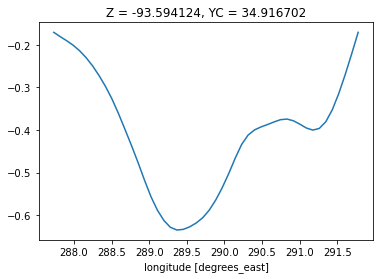

In [58]:
(us.isel(Z=kz) - usx*xr.DataArray(np.arange(len(us.XC)),
                                  dims=['XC'], coords={'XC':us.XC.data})
).isel(nmemb=0,Z=0,YC=10).plot()

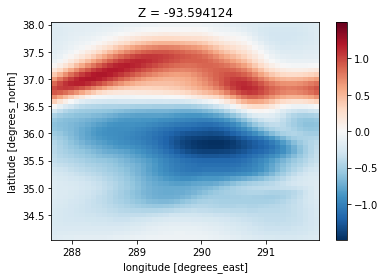

In [61]:
usdxdy.isel(nmemb=0,Z=0).plot()

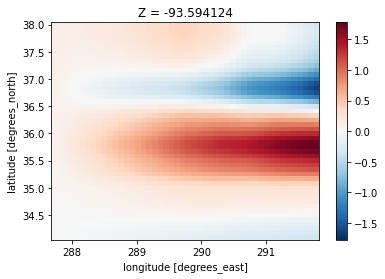

In [60]:
coru.isel(nmemb=0,Z=0).plot()

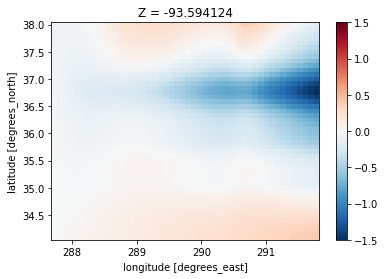

In [44]:
corv.isel(nmemb=0,Z=0).plot()

In [9]:
dx = gsw.distance([us.XC.isel(XC=23),us.XC.isel(XC=24)], 
                  [us.YC.isel(YC=23),us.YC.isel(YC=23)])
dy = gsw.distance([us.XC.isel(XC=23),us.XC.isel(XC=23)], 
                  [us.YC.isel(YC=23),us.YC.isel(YC=24)])
print(dx,dy)

[7741.79357876] [9266.52667037]


In [10]:
uxy_raw = xr.DataArray(us.isel(Z=kz).data, dims=['nmemb','Z','YC','XC'],
                   coords={'nmemb':range(35),'Z':us.Z.isel(Z=kz).data,
                           'YC':np.arange(0,48*dy,dy),
                           'XC':np.arange(0,48*dx,dx)[:-1]}
                  ).chunk({'nmemb':1,'Z':1})
vxy_raw = xr.DataArray(vs.isel(Z=kz).data, dims=['nmemb','Z','YC','XC'],
                   coords={'nmemb':range(35),'Z':vs.Z.isel(Z=kz).data,
                           'YC':np.arange(0,48*dy,dy),
                           'XC':np.arange(0,48*dx,dx)[:-1]}
                  ).chunk({'nmemb':1,'Z':1})
uxy = xr.DataArray(usdxdy.data, dims=['nmemb','Z','YC','XC'],
                   coords={'nmemb':range(35),'Z':us.Z.isel(Z=kz).data,
                           'YC':np.arange(0,48*dy,dy),
                           'XC':np.arange(0,48*dx,dx)[:-1]}
                  ).chunk({'nmemb':1,'Z':1})
vxy = xr.DataArray(vsdxdy.data, dims=['nmemb','Z','YC','XC'],
                   coords={'nmemb':range(35),'Z':vs.Z.isel(Z=kz).data,
                           'YC':np.arange(0,48*dy,dy),
                           'XC':np.arange(0,48*dx,dx)[:-1]}
                  ).chunk({'nmemb':1,'Z':1})

# uk = xrft.isotropic_power_spectrum(uxy.sel(Z=-94,method='nearest'), dim=['YC','XC'], window=True)
# vk = xrft.isotropic_power_spectrum(vxy.sel(Z=-94,method='nearest'), dim=['YC','XC'], window=True)
ukraw_xy = xrft.power_spectrum(uxy_raw, dim=['YC','XC'], window=None)
vkraw_xy = xrft.power_spectrum(vxy_raw, dim=['YC','XC'], window=None)
uk_xy = xrft.power_spectrum(uxy, dim=['YC','XC'], window=None)
vk_xy = xrft.power_spectrum(vxy, dim=['YC','XC'], window=None)
# uk_y = xrft.power_spectrum(uxy, dim=['YC'], window=None)
# vk_y = xrft.power_spectrum(vxy, dim=['YC'], window=None)
EKEraw_xy = .5*(ukraw_xy + vkraw_xy).mean('nmemb').compute()
EKE_xy = .5*(uk_xy + vk_xy).mean('nmemb').compute()
EKE_xy

<xarray.DataArray (Z: 2, freq_YC: 48, freq_XC: 48)>
array([[[0.12453696, 0.15076102, 0.17052824, ..., 0.24143754,
         0.17052824, 0.15076102],
        [0.1291133 , 0.14490325, 0.23849909, ..., 0.29292801,
         0.19660906, 0.13518284],
        [0.17963156, 0.21041161, 0.24473331, ..., 0.33447663,
         0.27714433, 0.24704954],
        ...,
        [0.23183089, 0.26116988, 0.25690749, ..., 0.29517575,
         0.26060058, 0.26993566],
        [0.17963156, 0.24704954, 0.27714433, ..., 0.32440653,
         0.24473331, 0.21041161],
        [0.1291133 , 0.13518284, 0.19660906, ..., 0.24710377,
         0.23849909, 0.14490325]],

       [[0.00136362, 0.00143127, 0.00148868, ..., 0.00163161,
         0.00148868, 0.00143127],
        [0.00144195, 0.00147017, 0.00152319, ..., 0.00176486,
         0.00152025, 0.0015091 ],
        [0.0014683 , 0.00161192, 0.00166977, ..., 0.00177005,
         0.00157239, 0.00143502],
        ...,
        [0.00171546, 0.00184255, 0.00192433, ..., 0.00203235,
         0.00191595, 0.00177506],
        [0.0014683 , 0.00143502, 0.00157239, ..., 0.00186115,
         0.00166977, 0.00161192],
        [0.00144195, 0.0015091 , 0.00152025, ..., 0.00171017,
         0.00152319, 0.00147017]]])
Coordinates:
  * Z        (Z) >f4 -93.59 -627.9
  * freq_YC  (freq_YC) float64 -5.396e-05 -5.171e-05 ... 4.946e-05 5.171e-05
  * freq_XC  (freq_XC) float64 -6.458e-05 -6.189e-05 ... 5.92e-05 6.189e-05

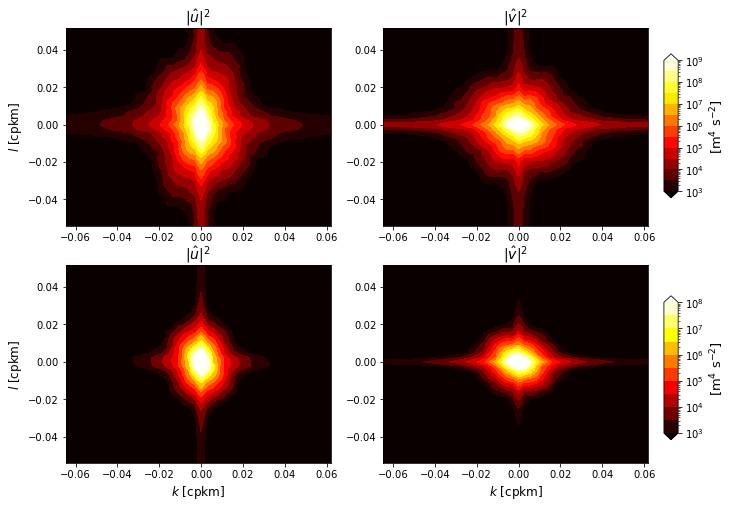

In [17]:
fig, axes = plt.subplots(figsize=(11,8), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im1 = axes[0,0].contourf(EKE_xy.freq_XC*1e3, EKE_xy.freq_YC*1e3, 
                   .5*uk_xy.sel(Z=-94,method='nearest').mean('nmemb'),
                   norm=clr.LogNorm(vmax=1e9,vmin=1e3), cmap='hot', 
                   levels=np.logspace(3,9,13), extend='both'
                  )
im2 = axes[0,1].contourf(EKE_xy.freq_XC*1e3, EKE_xy.freq_YC*1e3, 
                   .5*vk_xy.sel(Z=-94,method='nearest').mean('nmemb'),
                   norm=clr.LogNorm(vmax=1e9,vmin=1e3), cmap='hot', 
                   levels=np.logspace(3,9,13), extend='both'
                  )
im3 = axes[1,0].contourf(EKE_xy.freq_XC*1e3, EKE_xy.freq_YC*1e3, 
                   .5*uk_xy.sel(Z=-628,method='nearest').mean('nmemb'),
                   norm=clr.LogNorm(vmax=1e8,vmin=1e3), cmap='hot', 
                   levels=np.logspace(3,8,11), extend='both'
                  )
im4 = axes[1,1].contourf(EKE_xy.freq_XC*1e3, EKE_xy.freq_YC*1e3, 
                   .5*vk_xy.sel(Z=-628,method='nearest').mean('nmemb'),
                   norm=clr.LogNorm(vmax=1e8,vmin=1e3), cmap='hot', 
                   levels=np.logspace(3,8,13), extend='both'
                  )

for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)
for c in im3.collections:
    c.set_rasterized(True)
for c in im4.collections:
    c.set_rasterized(True)
    
axes[1,1].set_xlabel(r"$k$ [cpkm]", fontsize=12)
axes[0,0].set_ylabel(r"$l$ [cpkm]", fontsize=12)
axes[1,0].set_xlabel(r"$k$ [cpkm]", fontsize=12)
axes[1,0].set_ylabel(r"$l$ [cpkm]", fontsize=12)

axes[0,0].set_title(r"$|\hat{u}|^2$", fontsize=14)
axes[0,1].set_title(r"$|\hat{v}|^2$", fontsize=14)
axes[1,0].set_title(r"$|\hat{u}|^2$", fontsize=14)
axes[1,1].set_title(r"$|\hat{v}|^2$", fontsize=14)


fig.subplots_adjust(right=0.86)
cbaxes1 = fig.add_axes([0.88, 0.585, 0.018, 0.25]) 
cbar1 = fig.colorbar(im1, orientation='vertical', cax=cbaxes1)
cbar1.set_label(r"[m$^4$ s$^{-2}$]", fontsize=13)
cbaxes2 = fig.add_axes([0.88, 0.165, 0.018, 0.25]) 
cbar2 = fig.colorbar(im3, orientation='vertical', cax=cbaxes2)
cbar2.set_label(r"[m$^4$ s$^{-2}$]", fontsize=13)

plt.savefig(op.join(savedir,'Figs/2D_detrendedspectra_Z=-94_-628.pdf'))

In [11]:
EKEraw_diag = xr.zeros_like(EKEraw_xy.isel(freq_XC=0))
for i in range(yl):
    EKEraw_diag.isel(freq_YC=i)[:] = EKEraw_xy.isel(freq_YC=i, freq_XC=i).data
EKEraw_diag

<xarray.DataArray (Z: 2, freq_YC: 48)>
array([[1.06474980e+03, 1.08335654e+03, 1.11531838e+03, 1.16959742e+03,
        1.22618069e+03, 1.34229099e+03, 1.47971284e+03, 1.72370975e+03,
        1.90433332e+03, 2.34095024e+03, 2.94320306e+03, 3.58086908e+03,
        5.02504702e+03, 6.77799192e+03, 9.92542455e+03, 1.61695236e+04,
        3.44390389e+04, 7.33250636e+04, 1.92353750e+05, 5.54727571e+05,
        2.01902982e+06, 1.58839757e+07, 8.83283124e+07, 1.40837539e+09,
        1.01236181e+09, 1.40837539e+09, 8.83283124e+07, 1.58839757e+07,
        2.01902982e+06, 5.54727571e+05, 1.92353750e+05, 7.33250636e+04,
        3.44390389e+04, 1.61695236e+04, 9.92542455e+03, 6.77799192e+03,
        5.02504702e+03, 3.58086908e+03, 2.94320306e+03, 2.34095024e+03,
        1.90433332e+03, 1.72370975e+03, 1.47971284e+03, 1.34229099e+03,
        1.22618069e+03, 1.16959742e+03, 1.11531838e+03, 1.08335654e+03],
       [1.21245590e+02, 1.22356807e+02, 1.25570376e+02, 1.31262419e+02,
        1.39665192e+02, 1.51440365e+02, 1.67629782e+02, 1.88573421e+02,
        2.17222309e+02, 2.56320104e+02, 3.08705311e+02, 3.86088689e+02,
        4.96478302e+02, 6.51205753e+02, 9.53170195e+02, 1.37368782e+03,
        2.18193750e+03, 4.10367440e+03, 1.05868660e+04, 2.75541896e+04,
        1.13245580e+05, 8.11099336e+05, 7.26886436e+06, 2.21447907e+08,
        1.36031905e+08, 2.21447907e+08, 7.26886436e+06, 8.11099336e+05,
        1.13245580e+05, 2.75541896e+04, 1.05868660e+04, 4.10367440e+03,
        2.18193750e+03, 1.37368782e+03, 9.53170195e+02, 6.51205753e+02,
        4.96478302e+02, 3.86088689e+02, 3.08705311e+02, 2.56320104e+02,
        2.17222309e+02, 1.88573421e+02, 1.67629782e+02, 1.51440365e+02,
        1.39665192e+02, 1.31262419e+02, 1.25570376e+02, 1.22356807e+02]])
Coordinates:
  * Z        (Z) >f4 -93.59 -627.9
  * freq_YC  (freq_YC) float64 -5.396e-05 -5.171e-05 ... 4.946e-05 5.171e-05
    freq_XC  float64 -6.458e-05

In [12]:
EKE_diag = xr.zeros_like(EKE_xy.isel(freq_XC=0))
for i in range(yl):
    EKE_diag.isel(freq_YC=i)[:] = EKE_xy.isel(freq_YC=i, freq_XC=i).data
EKE_diag

<xarray.DataArray (Z: 2, freq_YC: 48)>
array([[1.24536955e-01, 1.44903254e-01, 2.44733310e-01, 2.95175750e-01,
        7.29125232e-01, 9.16067677e-01, 1.49436439e+00, 3.16008792e+00,
        5.02232889e+00, 8.77175477e+00, 1.92737331e+01, 3.40610382e+01,
        1.03264598e+02, 1.84313353e+02, 5.42573179e+02, 1.51716952e+03,
        4.92192461e+03, 9.73950967e+03, 3.27173912e+04, 1.10991923e+05,
        7.87978571e+05, 5.35137493e+06, 4.32700860e+07, 8.72223351e+08,
        9.33730522e+09, 8.72223351e+08, 4.32700860e+07, 5.35137493e+06,
        7.87978571e+05, 1.10991923e+05, 3.27173912e+04, 9.73950967e+03,
        4.92192461e+03, 1.51716952e+03, 5.42573179e+02, 1.84313353e+02,
        1.03264598e+02, 3.40610382e+01, 1.92737331e+01, 8.77175477e+00,
        5.02232889e+00, 3.16008792e+00, 1.49436439e+00, 9.16067677e-01,
        7.29125232e-01, 2.95175750e-01, 2.44733310e-01, 1.44903254e-01],
       [1.36361756e-03, 1.47016919e-03, 1.66976779e-03, 2.03234936e-03,
        2.90330974e-03, 3.72280757e-03, 4.98804333e-03, 8.84696463e-03,
        1.41508692e-02, 2.48393771e-02, 4.71449779e-02, 1.03716273e-01,
        3.06550215e-01, 1.09919090e+00, 4.93055920e+00, 2.25473972e+01,
        8.25432346e+01, 3.47458473e+02, 1.08349616e+03, 5.44037639e+03,
        3.07848324e+04, 2.83770221e+05, 3.14906032e+06, 1.22622439e+08,
        1.33128679e+09, 1.22622439e+08, 3.14906032e+06, 2.83770221e+05,
        3.07848324e+04, 5.44037639e+03, 1.08349616e+03, 3.47458473e+02,
        8.25432346e+01, 2.25473972e+01, 4.93055920e+00, 1.09919090e+00,
        3.06550215e-01, 1.03716273e-01, 4.71449779e-02, 2.48393771e-02,
        1.41508692e-02, 8.84696463e-03, 4.98804333e-03, 3.72280757e-03,
        2.90330974e-03, 2.03234936e-03, 1.66976779e-03, 1.47016919e-03]])
Coordinates:
  * Z        (Z) >f4 -93.59 -627.9
  * freq_YC  (freq_YC) float64 -5.396e-05 -5.171e-05 ... 4.946e-05 5.171e-05
    freq_XC  float64 -6.458e-05

In [13]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


In [14]:
ukraw_r = xrft.isotropic_power_spectrum(uxy_raw, dim=['YC','XC'], window=None, nfactor=2, truncate=True)
vkraw_r = xrft.isotropic_power_spectrum(vxy_raw, dim=['YC','XC'], window=None, nfactor=2, truncate=True)
uk_r = xrft.isotropic_power_spectrum(uxy, dim=['YC','XC'], window=None, nfactor=2, truncate=True)
vk_r = xrft.isotropic_power_spectrum(vxy, dim=['YC','XC'], window=None, nfactor=2, truncate=True)

EKEraw_r = .5*(ukraw_r + vkraw_r).mean('nmemb').compute()
EKE_r = .5*(uk_r + vk_r).mean('nmemb').compute()
EKE_r

<xarray.DataArray (Z: 2, freq_r: 15)>
array([[1.38469344e+04, 4.68956246e+03, 6.34866952e+02, 2.30725779e+02,
        3.76559668e+01, 1.44340067e+01, 3.48862243e+00, 1.78222508e+00,
        7.24645481e-01, 3.60588403e-01, 2.22377697e-01, 1.07838702e-01,
        1.09061995e-01, 8.59189312e-02, 6.85651348e-02],
       [2.04228859e+03, 5.10312127e+02, 3.47351382e+01, 6.15309355e+00,
        8.57840889e-01, 3.02319042e-01, 1.15368144e-01, 4.55999736e-02,
        2.34013982e-02, 1.88386019e-02, 1.26300933e-02, 6.94082070e-03,
        8.94604741e-03, 7.74891413e-03, 6.21177291e-03]])
Coordinates:
  * Z        (Z) >f4 -93.59 -627.9
  * freq_r   (freq_r) float64 1.976e-06 5.087e-06 ... 4.725e-05 5.085e-05

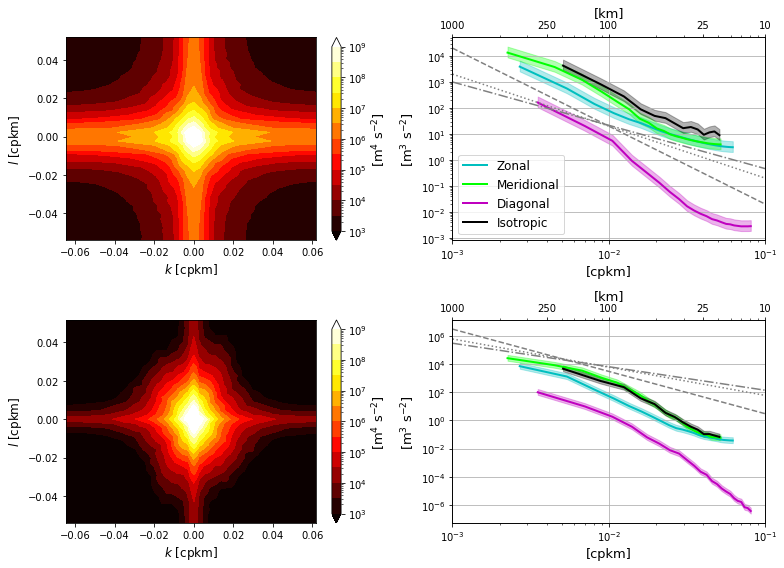

In [34]:
fig, axes = plt.subplots(figsize=(11,8), nrows=2, ncols=2)
fig.set_tight_layout(True)
ax1 = axes[0,0]
ax2 = axes[1,0]
ax5 = axes[0,1]
ax6 = axes[1,1]
ax7 = ax5.twiny()
ax8 = ax6.twiny()

im1 = ax1.contourf(EKEraw_xy.freq_XC*1e3, EKEraw_xy.freq_YC*1e3, 
                   EKEraw_xy.sel(Z=-94,method='nearest'),
                   norm=clr.LogNorm(vmax=1e9,vmin=1e3), cmap='hot', 
                   levels=np.logspace(3,9,13), extend='both'
                  )
im2 = ax2.contourf(EKE_xy.freq_XC*1e3, EKE_xy.freq_YC*1e3, 
                   EKE_xy.sel(Z=-94,method='nearest'),
                   norm=clr.LogNorm(vmax=1e9,vmin=1e3), cmap='hot', 
                   levels=np.logspace(3,9,13), extend='both'
                  )

for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)

ax5.plot(EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5)+1,None))*1e3, 
         (EKEraw_xy.sel(Z=-94,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
          * EKEraw_xy.freq_YC.diff('freq_YC')[0].data),
         c='c', lw=2, label='Zonal'
        )
ax5.plot(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5)+1,None))*1e3, 
         (EKEraw_xy.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
          * EKEraw_xy.freq_XC.diff('freq_XC')[0].data),
         c='lime', lw=2, label='Meridional'
        )
ax5.plot(np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                 + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                )[1:]*1e3, 
         (EKEraw_diag.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
          * np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                    + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                   )[1:] 
          * np.pi/2/xl),
         c='m', lw=2, label='Diagonal'
        )
ax5.plot(EKEraw_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
         (EKEraw_r.sel(Z=-94,method='nearest')).isel(freq_r=slice(1,None)),
         c='k', lw=2, label='Isotropic'
        )

ax5.fill_between(EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5)+1,None))*1e3, 
                 (EKEraw_xy.sel(Z=-94,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
                  * EKEraw_xy.freq_YC.diff('freq_YC')[0].data) * (35/low),
                 (EKEraw_xy.sel(Z=-94,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
                  * EKEraw_xy.freq_YC.diff('freq_YC')[0].data) * (35/high),
                 color='c', alpha=.3
        )
ax5.fill_between(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5)+1,None))*1e3, 
                 (EKEraw_xy.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
                  * EKEraw_xy.freq_XC.diff('freq_XC')[0].data) * (35/low),
                 (EKEraw_xy.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
                  * EKEraw_xy.freq_XC.diff('freq_XC')[0].data) * (35/high),
                 color='lime', alpha=.3
        )
ax5.fill_between(np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                         + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                        )[1:]*1e3, 
                 (EKEraw_diag.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
                  * np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                            + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                           )[1:] 
                  * np.pi/2/xl) * (35/low),
                 (EKEraw_diag.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
                  * np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                            + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                           )[1:] 
                  * np.pi/2/xl) * (35/high),
                 color='m', alpha=.3
        )
ax5.fill_between(EKEraw_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
                 (EKEraw_r.sel(Z=-94,method='nearest')).isel(freq_r=slice(1,None)) 
                 * (35/low),
                 (EKEraw_r.sel(Z=-94,method='nearest')).isel(freq_r=slice(1,None)) 
                 * (35/high),
                 color='k', alpha=.3
        )


ax5.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-3*2e-5,
         c='grey', ls='--'
        )
ax5.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-2*2e-3,
         c='grey', ls=':'
        )
ax5.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-(5/3)*1e-2,
         c='grey', ls='-.'
        )

##############################
ax6.plot(EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5)+1,None))*1e3, 
         (EKE_xy.sel(Z=-94,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
          * EKE_xy.freq_YC.diff('freq_YC')[0].data),
         c='c', lw=2, label='Zonal'
        )
ax6.plot(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5)+1,None))*1e3, 
         (EKE_xy.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
          * EKE_xy.freq_XC.diff('freq_XC')[0].data),
         c='lime', lw=2, label='Meridional'
        )
ax6.plot(np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                 + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                )[1:]*1e3, 
         (EKE_diag.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
          * np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                    + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                   )[1:] 
          * np.pi/2/xl),
         c='m', lw=2, label='Diagonal'
        )
ax6.plot(EKE_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
         (EKE_r.sel(Z=-94,method='nearest')).isel(freq_r=slice(1,None)),
         c='k', lw=2, label='Isotropic'
        )

ax6.fill_between(EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5)+1,None))*1e3, 
                 (EKE_xy.sel(Z=-94,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
                  * EKE_xy.freq_YC.diff('freq_YC')[0].data) * (35/low),
                 (EKE_xy.sel(Z=-94,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
                  * EKE_xy.freq_YC.diff('freq_YC')[0].data) * (35/high),
                 color='c', alpha=.3
        )
ax6.fill_between(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5)+1,None))*1e3, 
                 (EKE_xy.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
                  * EKE_xy.freq_XC.diff('freq_XC')[0].data) * (35/low),
                 (EKE_xy.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
                  * EKE_xy.freq_XC.diff('freq_XC')[0].data) * (35/high),
                 color='lime', alpha=.3
        )
ax6.fill_between(np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                         + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                        )[1:]*1e3, 
                 (EKE_diag.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
                  * np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                            + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                           )[1:] 
                  * np.pi/2/xl) * (35/low),
                 (EKE_diag.sel(Z=-94,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
                  * np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                            + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                           )[1:] 
                  * np.pi/2/xl) * (35/high),
                 color='m', alpha=.3
        )
ax6.fill_between(EKE_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
                 (EKE_r.sel(Z=-94,method='nearest')).isel(freq_r=slice(1,None)) 
                 * (35/low),
                 (EKE_r.sel(Z=-94,method='nearest')).isel(freq_r=slice(1,None)) 
                 * (35/high),
                 color='k', alpha=.3
        )


ax6.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-3*3e-3,
         c='grey', ls='--'
        )
ax6.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-2*6e-1,
         c='grey', ls=':'
        )
ax6.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-(5/3)*3e0,
         c='grey', ls='-.'
        )

ax7.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-3*2e-5,
         alpha=0.
        )
ax8.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-3*3e-6,
         alpha=0.
        )

ax1.set_xlabel(r"$k$ [cpkm]", fontsize=12)
ax1.set_ylabel(r"$l$ [cpkm]", fontsize=12)
ax2.set_xlabel(r"$k$ [cpkm]", fontsize=12)
ax2.set_ylabel(r"$l$ [cpkm]", fontsize=12)
# ax1.plot(np.linspace(3e-3,8e-3), np.linspace(3e-3,6e-3)**-3*4.3e-19, c='k')
# ax1.plot(np.linspace(3e-3,8e-3), np.linspace(3e-3,6e-3)**-(5/3)*1e-15, c='r')
# ax5.plot(np.linspace(1.5e-2,4e-2), np.linspace(1.5e-2,4e-2)**-3*3.8e-20, c='k')
# ax5.plot(np.linspace(1.5e-2,4e-2), np.linspace(1.5e-2,4e-2)**-(5/3)*1e-17, c='r')
# ax3.plot(uk_x.freq_XC*1e3, np.ones_like(uk_x.freq_XC), alpha=0)
# ax7.plot(uk_x.freq_XC*1e3, np.ones_like(uk_x.freq_XC), alpha=0)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax7.set_xscale('log')
ax7.set_yscale('log')
ax8.set_xscale('log')
ax8.set_yscale('log')
ax5.grid(True)
ax6.grid(True)
ax5.set_xlim([1e-3,1e-1])
ax6.set_xlim([1e-3,1e-1])
ax7.set_xlim([1e-3,1e-1])
ax8.set_xlim([1e-3,1e-1])

ax7.set_xticks([1e-3,4e-3,1e-2,4e-2,1e-1])
ax7.set_xticklabels([1000,250,100,25,10])

ax8.set_xticks([1e-3,4e-3,1e-2,4e-2,1e-1])
ax8.set_xticklabels([1000,250,100,25,10])
ax5.set_xlabel(r"[cpkm]", fontsize=13)
ax5.set_ylabel(r"[m$^3$ s$^{-2}$]", fontsize=13)
ax6.set_xlabel(r"[cpkm]", fontsize=13)
ax6.set_ylabel(r"[m$^3$ s$^{-2}$]", fontsize=13)
ax7.set_xlabel(r"[km]", fontsize=13)
ax8.set_xlabel(r"[km]", fontsize=13)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar1.set_label(r"[m$^4$ s$^{-2}$]", fontsize=13)
cbar2.set_label(r"[m$^4$ s$^{-2}$]", fontsize=13)
ax5.legend(loc='lower left', fontsize=12)

plt.savefig(op.join(savedir,'Figs/2D_1D-detrendedspectra_Z=-94.pdf'))

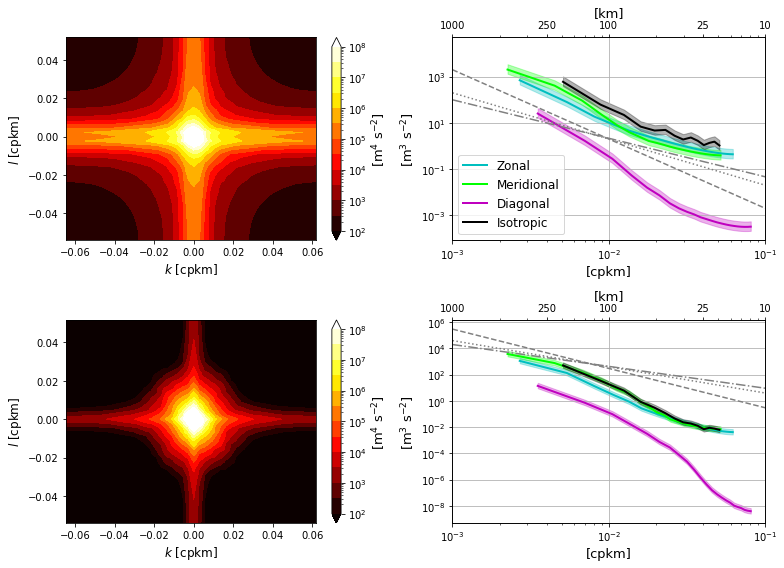

In [36]:
fig, axes = plt.subplots(figsize=(11,8), nrows=2, ncols=2)
fig.set_tight_layout(True)
ax1 = axes[0,0]
ax2 = axes[1,0]
ax5 = axes[0,1]
ax6 = axes[1,1]
ax7 = ax5.twiny()
ax8 = ax6.twiny()

im1 = ax1.contourf(EKEraw_xy.freq_XC*1e3, EKEraw_xy.freq_YC*1e3, 
                   EKEraw_xy.sel(Z=-628,method='nearest'),
                   norm=clr.LogNorm(vmax=1e8,vmin=1e2), cmap='hot', 
                   levels=np.logspace(2,8,13), extend='both'
                  )
im2 = ax2.contourf(EKE_xy.freq_XC*1e3, EKE_xy.freq_YC*1e3, 
                   EKE_xy.sel(Z=-628,method='nearest'),
                   norm=clr.LogNorm(vmax=1e8,vmin=1e2), cmap='hot', 
                   levels=np.logspace(2,8,13), extend='both'
                  )

for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)


ax5.plot(EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5)+1,None))*1e3, 
         (EKEraw_xy.sel(Z=-628,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
          * EKEraw_xy.freq_YC.diff('freq_YC')[0].data),
         c='c', lw=2, label='Zonal'
        )
ax5.plot(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5)+1,None))*1e3, 
         (EKEraw_xy.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
          * EKEraw_xy.freq_XC.diff('freq_XC')[0].data),
         c='lime', lw=2, label='Meridional'
        )
ax5.plot(np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                 + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                )[1:]*1e3, 
         (EKEraw_diag.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
          * np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                    + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                   )[1:] 
          * np.pi/2/xl),
         c='m', lw=2, label='Diagonal'
        )
ax5.plot(EKEraw_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
         (EKEraw_r.sel(Z=-628,method='nearest')).isel(freq_r=slice(1,None)),
         c='k', lw=2, label='Isotropic'
        )

ax5.fill_between(EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5)+1,None))*1e3, 
                 (EKEraw_xy.sel(Z=-628,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
                  * EKEraw_xy.freq_YC.diff('freq_YC')[0].data) * (35/low),
                 (EKEraw_xy.sel(Z=-628,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
                  * EKEraw_xy.freq_YC.diff('freq_YC')[0].data) * (35/high),
                 color='c', alpha=.3
        )
ax5.fill_between(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5)+1,None))*1e3, 
                 (EKEraw_xy.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
                  * EKEraw_xy.freq_XC.diff('freq_XC')[0].data) * (35/low),
                 (EKEraw_xy.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
                  * EKEraw_xy.freq_XC.diff('freq_XC')[0].data) * (35/high),
                 color='lime', alpha=.3
        )
ax5.fill_between(np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                         + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                        )[1:]*1e3, 
                 (EKEraw_diag.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
                  * np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                            + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                           )[1:] 
                  * np.pi/2/xl) * (35/low),
                 (EKEraw_diag.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
                  * np.sqrt(EKEraw_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                            + EKEraw_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                           )[1:] 
                  * np.pi/2/xl) * (35/high),
                 color='m', alpha=.3
        )
ax5.fill_between(EKEraw_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
                 (EKEraw_r.sel(Z=-628,method='nearest')).isel(freq_r=slice(1,None)) 
                 * (35/low),
                 (EKEraw_r.sel(Z=-628,method='nearest')).isel(freq_r=slice(1,None)) 
                 * (35/high),
                 color='k', alpha=.3
        )


ax5.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-3*2e-6,
         c='grey', ls='--'
        )
ax5.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-2*2e-4,
         c='grey', ls=':'
        )
ax5.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-(5/3)*1e-3,
         c='grey', ls='-.'
        )

ax6.plot(EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5)+1,None))*1e3, 
         (EKE_xy.sel(Z=-628,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
          * EKE_xy.freq_YC.diff('freq_YC')[0].data),
         c='c', lw=2, label='Zonal'
        )
ax6.plot(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5)+1,None))*1e3, 
         (EKE_xy.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
          * EKE_xy.freq_XC.diff('freq_XC')[0].data),
         c='lime', lw=2, label='Meridional'
        )
ax6.plot(np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                 + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                )[1:]*1e3, 
         (EKE_diag.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
          * np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                    + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                   )[1:] 
          * np.pi/2/xl),
         c='m', lw=2, label='Diagonal'
        )
ax6.plot(EKE_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
         (EKE_r.sel(Z=-628,method='nearest')).isel(freq_r=slice(1,None)),
         c='k', lw=2, label='Isotropic'
        )

ax6.fill_between(EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5)+1,None))*1e3, 
                 (EKE_xy.sel(Z=-628,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
                  * EKE_xy.freq_YC.diff('freq_YC')[0].data) * (35/low),
                 (EKE_xy.sel(Z=-628,method='nearest').sel(freq_YC=0.).isel(freq_XC=slice(-int(xl*.5)+1,None))
                  * EKE_xy.freq_YC.diff('freq_YC')[0].data) * (35/high),
                 color='c', alpha=.3
        )
ax6.fill_between(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5)+1,None))*1e3, 
                 (EKE_xy.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
                  * EKE_xy.freq_XC.diff('freq_XC')[0].data) * (35/low),
                 (EKE_xy.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None)).sel(freq_XC=0.)
                  * EKE_xy.freq_XC.diff('freq_XC')[0].data) * (35/high),
                 color='lime', alpha=.3
        )
ax6.fill_between(np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                         + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                        )[1:]*1e3, 
                 (EKE_diag.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
                  * np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                            + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                           )[1:] 
                  * np.pi/2/xl) * (35/low),
                 (EKE_diag.sel(Z=-628,method='nearest').isel(freq_YC=slice(-int(yl*.5)+1,None))
                  * np.sqrt(EKE_xy.freq_YC.isel(freq_YC=slice(-int(yl*.5),None)).data**2
                            + EKE_xy.freq_XC.isel(freq_XC=slice(-int(xl*.5),None)).data**2
                           )[1:] 
                  * np.pi/2/xl) * (35/high),
                 color='m', alpha=.3
        )
ax6.fill_between(EKE_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
                 (EKE_r.sel(Z=-628,method='nearest')).isel(freq_r=slice(1,None)) 
                 * (35/low),
                 (EKE_r.sel(Z=-628,method='nearest')).isel(freq_r=slice(1,None)) 
                 * (35/high),
                 color='k', alpha=.3
        )


ax6.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-3*3e-4,
         c='grey', ls='--'
        )
ax6.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-2*4e-2,
         c='grey', ls=':'
        )
ax6.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-(5/3)*2e-1,
         c='grey', ls='-.'
        )

ax7.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-3*2e-5,
         alpha=0.
        )
ax8.plot(np.linspace(1e-3,1e-1,5), 
         np.linspace(1e-3,1e-1,5)**-3*3e-6,
         alpha=0.
        )

ax1.set_xlabel(r"$k$ [cpkm]", fontsize=12)
ax1.set_ylabel(r"$l$ [cpkm]", fontsize=12)
ax2.set_xlabel(r"$k$ [cpkm]", fontsize=12)
ax2.set_ylabel(r"$l$ [cpkm]", fontsize=12)

ax5.set_xscale('log')
ax5.set_yscale('log')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax7.set_xscale('log')
ax7.set_yscale('log')
ax8.set_xscale('log')
ax8.set_yscale('log')
ax5.grid(True)
ax6.grid(True)
ax5.set_xlim([1e-3,1e-1])
ax6.set_xlim([1e-3,1e-1])
ax7.set_xlim([1e-3,1e-1])
ax8.set_xlim([1e-3,1e-1])

ax7.set_xticks([1e-3,4e-3,1e-2,4e-2,1e-1])
ax7.set_xticklabels([1000,250,100,25,10])

ax8.set_xticks([1e-3,4e-3,1e-2,4e-2,1e-1])
ax8.set_xticklabels([1000,250,100,25,10])

ax5.set_xlabel(r"[cpkm]", fontsize=13)
ax5.set_ylabel(r"[m$^3$ s$^{-2}$]", fontsize=13)
ax6.set_xlabel(r"[cpkm]", fontsize=13)
ax6.set_ylabel(r"[m$^3$ s$^{-2}$]", fontsize=13)
ax7.set_xlabel(r"[km]", fontsize=13)
ax8.set_xlabel(r"[km]", fontsize=13)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar1.set_label(r"[m$^4$ s$^{-2}$]", fontsize=13)
cbar2.set_label(r"[m$^4$ s$^{-2}$]", fontsize=13)
ax5.legend(loc='lower left', fontsize=12)

plt.savefig(op.join(savedir,'Figs/2D_1D-detrendedspectra_Z=-628.pdf'))

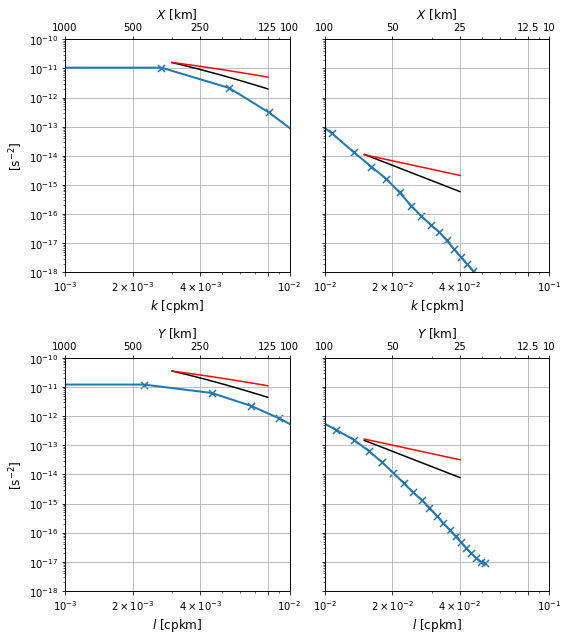

In [47]:
_,_,Ny,Nx = us.shape

fig, axes = plt.subplots(figsize=(8,9), nrows=2, ncols=2)
fig.set_tight_layout(True)
ax1 = axes[0,0]
ax2 = axes[1,0]
ax5 = axes[0,1]
ax6 = axes[1,1]
ax3 = ax1.twiny()
ax4 = ax2.twiny()
ax7 = ax5.twiny()
ax8 = ax6.twiny()
ax1.plot(uk_x.freq_XC*1e3, (uk_x+vk_x).sel(Z=-94,method='nearest').mean(['nmemb','YC'])/area/Nx, 
         '-', lw=2)
ax5.plot(uk_x.freq_XC*1e3, (uk_x+vk_x).sel(Z=-94,method='nearest').mean(['nmemb','YC'])/area/Nx, 
         '-', lw=2)
ax1.scatter(uk_x.freq_XC*1e3, (uk_x+vk_x).sel(Z=-94,method='nearest').mean(['nmemb','YC'])/area/Nx, 
            marker='x', s=50)
ax5.scatter(uk_x.freq_XC*1e3, (uk_x+vk_x).sel(Z=-94,method='nearest').mean(['nmemb','YC'])/area/Nx, 
            marker='x', s=50)
ax1.plot(np.linspace(3e-3,8e-3), np.linspace(3e-3,6e-3)**-3*4.3e-19, c='k')
ax1.plot(np.linspace(3e-3,8e-3), np.linspace(3e-3,6e-3)**-(5/3)*1e-15, c='r')
ax5.plot(np.linspace(1.5e-2,4e-2), np.linspace(1.5e-2,4e-2)**-3*3.8e-20, c='k')
ax5.plot(np.linspace(1.5e-2,4e-2), np.linspace(1.5e-2,4e-2)**-(5/3)*1e-17, c='r')
ax3.plot(uk_x.freq_XC*1e3, np.ones_like(uk_x.freq_XC), alpha=0)
ax7.plot(uk_x.freq_XC*1e3, np.ones_like(uk_x.freq_XC), alpha=0)
ax1.set_xscale('log')
ax3.set_xscale('log')
ax1.set_yscale('log')
ax5.set_xscale('log')
ax5.set_yscale('log')
ax7.set_xscale('log')
ax7.set_yscale('log')
ax1.set_xlim([1e-3,1e-2])
ax3.set_xlim([1e-3,1e-2])
ax5.set_xlim([1e-2,1e-1])
ax7.set_xlim([1e-2,1e-1])
ax1.set_ylim([1e-18,1e-10])
ax5.set_ylim([1e-18,1e-10])
ax1.set_xticks([1e-3,1e-2])
ax5.set_yticks([1e-18,1e-17,1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10])
ax5.set_yticklabels([])
ax1.set_xticks([1e-3,2e-3,4e-3,8e-3,1e-2])
# ax1.set_xticklabels([1e-3,2e-3,4e-3,8e-3,1e-2])
ax3.set_xticks([1e-3,2e-3,4e-3,8e-3,1e-2])
ax3.set_xticklabels([1000,500,250,125,100])
ax1.get_xaxis().set_minor_formatter(mticker.NullFormatter())
ax3.get_xaxis().set_minor_formatter(mticker.NullFormatter())
ax5.set_xticks([1e-2,2e-2,4e-2,8e-2,1e-1])
ax7.set_xticks([1e-2,2e-2,4e-2,8e-2,1e-1])
ax7.set_xticklabels([100,50,25,12.5,10])
ax5.get_xaxis().set_minor_formatter(mticker.NullFormatter())
ax7.get_xaxis().set_minor_formatter(mticker.NullFormatter())
ax1.set_xlabel(r"$k$ [cpkm]", fontsize=12)
ax1.set_ylabel(r"[s$^{-2}$]", fontsize=12)
ax3.set_xlabel(r"$X$ [km]", fontsize=12)
ax5.set_xlabel(r"$k$ [cpkm]", fontsize=12)
ax7.set_xlabel(r"$X$ [km]", fontsize=12)
ax2.plot(vk_y.freq_YC*1e3, (uk_y+vk_y).sel(Z=-94,method='nearest').mean(['nmemb','XC'])/area/Ny, 
         '-', lw=2)
ax6.plot(vk_y.freq_YC*1e3, (uk_y+vk_y).sel(Z=-94,method='nearest').mean(['nmemb','XC'])/area/Ny, 
         '-', lw=2)
ax2.scatter(vk_y.freq_YC*1e3, (uk_y+vk_y).sel(Z=-94,method='nearest').mean(['nmemb','XC'])/area/Ny,
            marker='x', s=50)
ax6.scatter(vk_y.freq_YC*1e3, (uk_y+vk_y).sel(Z=-94,method='nearest').mean(['nmemb','XC'])/area/Ny,
            marker='x', s=50)
ax2.plot(np.linspace(3e-3,8e-3), np.linspace(3e-3,6e-3)**-3*9.6e-19, c='k')
ax2.plot(np.linspace(3e-3,8e-3), np.linspace(3e-3,6e-3)**-(5/3)*2.2e-15, c='r')
ax6.plot(np.linspace(1.5e-2,4e-2), np.linspace(1.5e-2,4e-2)**-3*5e-19, c='k')
ax6.plot(np.linspace(1.5e-2,4e-2), np.linspace(1.5e-2,4e-2)**-(5/3)*1.5e-16, c='r')
ax4.plot(vk_y.freq_YC*1e3, np.ones_like(vk_y.freq_YC), alpha=0)
ax8.plot(vk_y.freq_YC*1e3, np.ones_like(vk_y.freq_YC), alpha=0)
ax2.set_xscale('log')
ax4.set_xscale('log')
ax2.set_yscale('log')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax8.set_xscale('log')
ax8.set_yscale('log')
ax2.set_xlim([1e-3,1e-2])
ax4.set_xlim([1e-3,1e-2])
ax6.set_xlim([1e-2,1e-1])
ax8.set_xlim([1e-2,1e-1])
ax2.set_ylim([1e-18,1e-10])
ax6.set_ylim([1e-18,1e-10])
ax2.set_xticks([1e-3,1e-2])
# ax2.set_yticks([1e-11,1e-10,1e-9,1e-8])
# ax2.set_yticklabels([])
ax6.set_yticks([1e-18,1e-17,1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10])
ax6.set_yticklabels([])
ax2.set_xticks([1e-3,2e-3,4e-3,8e-3,1e-2])
ax4.set_xticks([1e-3,2e-3,4e-3,8e-3,1e-2])
ax4.set_xticklabels([1000,500,250,125,100])
ax2.get_xaxis().set_minor_formatter(mticker.NullFormatter())
ax4.get_xaxis().set_minor_formatter(mticker.NullFormatter())
ax6.set_xticks([1e-2,2e-2,4e-2,8e-2,1e-1])
ax8.set_xticks([1e-2,2e-2,4e-2,8e-2,1e-1])
ax8.set_xticklabels([100,50,25,12.5,10])
ax6.get_xaxis().set_minor_formatter(mticker.NullFormatter())
ax8.get_xaxis().set_minor_formatter(mticker.NullFormatter())
ax2.set_xlabel(r"$l$ [cpkm]", fontsize=12)
ax2.set_ylabel(r"[s$^{-2}$]", fontsize=12)
ax4.set_xlabel(r"$Y$ [km]", fontsize=12)
ax6.set_xlabel(r"$l$ [cpkm]", fontsize=12)
ax8.set_xlabel(r"$Y$ [km]", fontsize=12)
ax1.grid(True)
ax2.grid(True)
ax5.grid(True)
ax6.grid(True)

plt.savefig(op.join(savedir,'Figs/Fourier-spectra_Z=-94.pdf'))

In [12]:
# matdir = '/tank/chaocean/MITgcm/utils/matlab/'
# f = open(savedir + 'Fig-7/uveofs', 'r')
f = open(savedir + 'uveofs_36', 'r')
eofs = np.fromfile(f, '>f4').reshape((2,35,2,48,48))   # big-indian ('>'), real*4 ('f4')    
f.close()
uv = eofs[:,:,0]
vv = eofs[:,:,1]
# uv = xr.DataArray(uv, dims=['Z','mode','YC','XC'],
#                   coords={'Z':np.array([94,628]),
#                           'YC':np.arange(0,DYC.isel(YG=Yr,XC=Xr).mean()*48,DYC.isel(YG=Yr,XC=Xr).mean()),
#                           'XC':np.arange(0,DXC.isel(YC=Yr,XG=Xr).mean()*48,DXC.isel(YC=Yr,XG=Xr).mean())}
#                  )
# vv = xr.DataArray(vv, dims=['Z','mode','YC','XC'],
#                   coords={'Z':np.array([94,628]),
#                           'YC':np.arange(DYC.isel(YG=Yr,XC=Xr).mean()*48,
#                                          DYC.isel(YG=Yr,XC=Xr).mean()*96,DYC.isel(YG=Yr,XC=Xr).mean()),
#                           'XC':np.arange(0,DXC.isel(YC=Yr,XG=Xr).mean()*48,DXC.isel(YC=Yr,XG=Xr).mean())}
#                  )

# f = open(savedir + 'Fig-7/uveigs', 'r')
f = open(savedir + 'uveigs_36', 'r')
eigs = np.fromfile(f, '>f4').reshape((2,35))   # big-indian ('>'), real*4 ('f4')   
f.close()
print(eofs.shape, eigs.shape)

(2, 35, 2, 48, 48) (2, 35)


In [13]:
dxcs = dg.dxC.isel(YC=Yr,XG=Xr)
dycs = dg.dyC.isel(YG=Yr,XC=Xr)

uvx = np.zeros((2,48,47))
uvy = np.zeros((2,47,48))
vvx = np.zeros((2,48,47))
vvy = np.zeros((2,47,48))
k2 = np.zeros((2,35))
l2 = np.zeros((2,35))
for kz in range(2):
    
    for k in range(35):
        uvx[kz] = (uv[kz,k,:,1:]-uv[kz,k,:,:-1]) / dxcs[:,:-1]
        uvy[kz] = (uv[kz,k,1:]-uv[kz,k,:-1]) / dycs[:-1]
        vvx[kz] = (vv[kz,k,:,1:]-vv[kz,k,:,:-1]) / dxcs[:,:-1]
        vvy[kz] = (vv[kz,k,1:]-vv[kz,k,:-1]) / dycs[:-1]
        k2[kz,k] = np.sum(np.sum(uvx[kz]**2+vvx[kz]**2,1),0)
        l2[kz,k] = np.sum(np.sum(uvy[kz]**2+vvy[kz]**2,1),0)
        
keff = np.sqrt(k2)
leff = np.sqrt(l2)

Keff = np.sqrt(keff**2 + leff**2)
Keff

array([[1.71788944e-05, 2.02326658e-05, 2.06415947e-05, 2.46520807e-05,
        2.79746175e-05, 2.59442962e-05, 3.07947593e-05, 2.77727232e-05,
        2.95749360e-05, 3.76379108e-05, 3.22435746e-05, 3.54483083e-05,
        3.59973046e-05, 3.52288675e-05, 3.50433988e-05, 4.59308721e-05,
        3.88876934e-05, 3.70253180e-05, 4.01505765e-05, 4.63885383e-05,
        4.86281058e-05, 4.07720890e-05, 5.02210383e-05, 5.00715921e-05,
        5.08470638e-05, 5.16955525e-05, 5.14130986e-05, 5.22324784e-05,
        5.69787203e-05, 6.13845949e-05, 5.05285220e-05, 5.68534207e-05,
        6.31207185e-05, 5.71521928e-05, 4.62835554e-05],
       [1.71043139e-05, 1.78874498e-05, 1.90083793e-05, 1.92070113e-05,
        2.38329351e-05, 2.09690520e-05, 2.07628594e-05, 2.44675457e-05,
        2.67711415e-05, 2.60052989e-05, 2.88934651e-05, 2.88524479e-05,
        2.86987568e-05, 2.90391944e-05, 3.04793526e-05, 3.65066721e-05,
        3.51092719e-05, 3.87828281e-05, 3.56058968e-05, 3.66658984e-05,
       

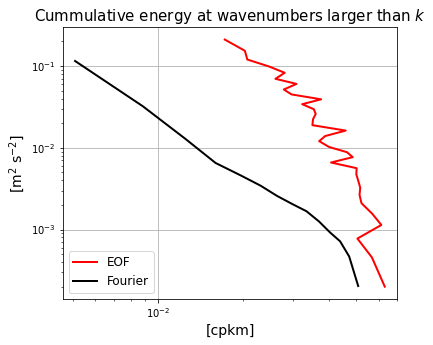

In [36]:
fig, ax = plt.subplots(figsize=(6,5))
# ax2 = ax.twiny()

ax.plot(Keff[0,:33]*1e3, np.flip(np.cumsum(np.flip(eigs[0,:33]))), 
        c='r', lw=2, label=r"EOF")
ax.plot(EKEraw_r.freq_r.isel(freq_r=slice(1,None))*1e3, 
        np.flip(np.cumsum(np.flip(EKEraw_r.sel(Z=-94,method='nearest').isel(freq_r=slice(1,None))
                                  * EKEraw_r.freq_r.diff('freq_r')*2*np.pi))),
        c='k', lw=2, label=r"Fourier"
       )

ax.set_xlim([4.6e-3,7e-2])

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='lower left', fontsize=12)
ax.set_xlabel(r"[cpkm]", fontsize=14)

ax.set_ylabel(r"[m$^2$ s$^{-2}$]", fontsize=14)
ax.grid(True)
ax.set_title(r"Cummulative energy at wavenumbers larger than $k$", fontsize=15);